В данном проекте вам предстоит поработать с деконволюцией bulk-RNAseq данных. Исходные данные можно найти [здесь](https://drive.google.com/file/d/1gB2eHRyCHyGSSvtZq47ayoVA3GPDMNDX/view?usp=sharing).

* `Annotation_cell_lines.tsv.gz`: Аннотация раковых линий
* `Annotation_cells.tsv.gz`: Аннотация клеточных линий
* `Expression_cell_lines.tsv.gz`: Экспрессии раковых линий
* `Expression_cells.tsv.gz`: Экспрессии клеточных линий
* `LUAD-expr.tsv`: bulk-RNAseq крови больного раком легкого
* `Normal-blood-expr.tsv`: bulk-RNAseq здоровой крови

Деконволюция - это процесс при котором мы хотим достать пропорции отдельных типов клеток из bulk-RNAseq данных. Для этого мы можем обучить регрессионные модели, которые будут предсказывать пропоции каждого клеточного типа. К сожалению, у нас весьма мало тренировочных данных, поэтому вам предлагается в начале заняться генерацией данных, а уже потом обучить модели.

Вам предлагаются данные экспрессий "чистых" клеток (линии). Bulk данные можно представить как линейная комбинация экспрессий "чистых" клеток. Например, `0.5 * B_cell + 0.5 * T_cell = Bulk_dataset`. В таком случае мы можем взять "чистые" клетки в различных пропорциях и получить размеченные искусственные bulk-RNAseq данные. `np.random....`

Дальше можно обучить несколько моделей для предсказания содержания каждого клеточного типа.

В результате вы должны получить программу, которая принимает на вход bulk-RNAseq данные, а на выходе выдает пропорции всех клеточных типов. Получите предсказания для `LUAD-expr.tsv` и `Normal-blood-expr.tsv`.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from umap import UMAP

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

import optuna

from xgboost import XGBRegressor

import torch
import torch.nn as nn
import torch.optim as optim

# 0. Data loading and checking

In [4]:
ann_cancer = pd.read_csv('Annotation_cell_lines.tsv.gz', sep='\t', index_col=0)
ann_cancer

,srr_h,dataset_h,tumor_type,line_name,comment
0,srr_cell_0,dataset_cell_0,BRCA,T47D,NaN
1,srr_cell_1,dataset_cell_0,BRCA,T47D,NaN
2,srr_cell_2,dataset_cell_0,BRCA,MDA-MB-231,NaN
3,srr_cell_3,dataset_cell_0,BRCA,MDA-MB-231,NaN
4,srr_cell_4,dataset_cell_0,BRCA,T47D,NaN
...,...,...,...,...,...
229,srr_cell_229,dataset_cell_1,LUAD,A549,lung carcinoma cells_overexpression_control em...
230,srr_cell_230,dataset_cell_1,LUAD,A549,lung carcinoma cells_overexpression_control em...
231,srr_cell_231,dataset_cell_1,LUAD,A549,lung carcinoma cells_overexpression_EHF
232,srr_cell_232,dataset_cell_1,LUAD,A549,lung carcinoma cells_overexpression_control em...


<Axes: ylabel='count'>

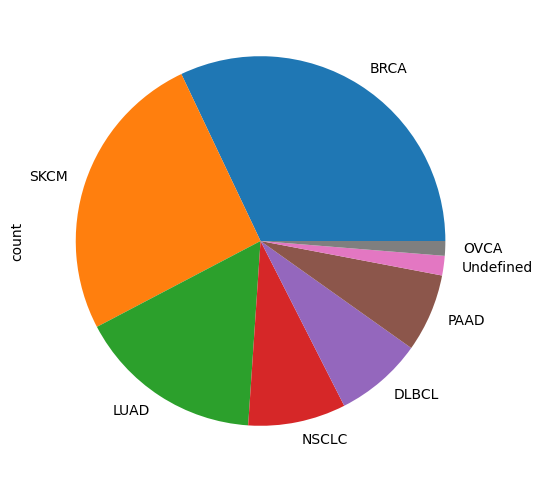

In [4]:
ann_cancer.tumor_type.value_counts().plot(kind='pie', figsize=(6,6))

In [3]:
ann_cancer.groupby(['tumor_type'])['dataset_h'].value_counts()

tumor_type  dataset_h      
BRCA        dataset_cell_14    44
            dataset_cell_9     16
            dataset_cell_0      8
            dataset_cell_10     4
            dataset_cell_11     3
DLBCL       dataset_cell_13     8
            dataset_cell_15     6
            dataset_cell_12     3
            dataset_cell_16     1
LUAD        dataset_cell_1     26
            dataset_cell_3      4
            dataset_cell_4      4
            dataset_cell_7      4
NSCLC       dataset_cell_17    20
OVCA        dataset_cell_11     3
PAAD        dataset_cell_8     10
            dataset_cell_2      6
SKCM        dataset_cell_6     48
            dataset_cell_11     6
            dataset_cell_5      6
Undefined   dataset_cell_16     3
            dataset_cell_12     1
Name: count, dtype: int64

<Axes: ylabel='count'>

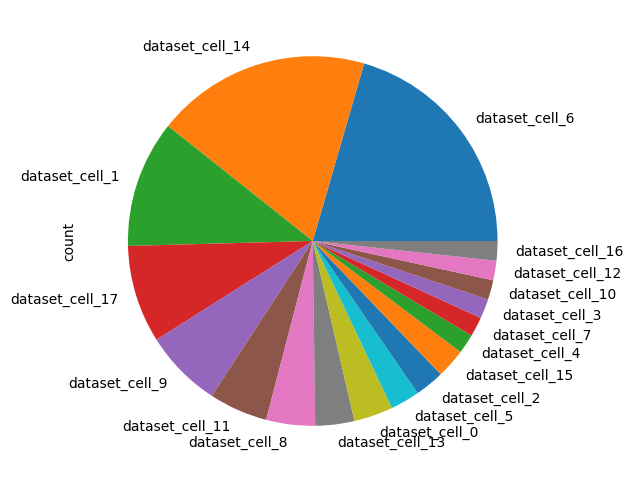

In [ ]:
ann_cancer['dataset_h'].value_counts().plot(kind='pie', figsize=(6,6))

In [5]:
ann_normal = pd.read_csv('Annotation_cells.tsv.gz', sep='\t', index_col=0)
ann_normal

,srr_h,dataset_h,general_cell_type,particular_cell_type
0,srr_0,dataset_0,B_cells,B-Cells
1,srr_1,dataset_0,B_cells,B-Cells
2,srr_2,dataset_0,B_cells,B-Cells
3,srr_3,dataset_0,B_cells,B-Cells
4,srr_4,dataset_0,B_cells,B-Cells
...,...,...,...,...
983,srr_983,dataset_44,Macrophages,Monocyte-derived macrophages
984,srr_984,dataset_44,Macrophages,Monocyte-derived macrophages
985,srr_985,dataset_64,CD8_T_cells,FoxO1 mRNA treatedcultured for 3 days
986,srr_986,dataset_44,Macrophages,Monocyte-derived macrophages


In [6]:
ann_normal.general_cell_type.value_counts().to_frame()

,count
general_cell_type,
Macrophages,406
Fibroblasts,166
CD4_T_cells,138
B_cells,92
CD8_T_cells,83
NK_cells,33
Monocytes,28
Neutrophils,20
T_cells,16


<Axes: ylabel='count'>

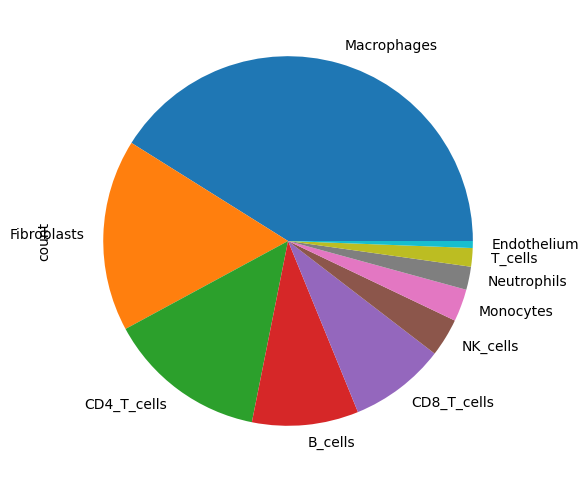

In [7]:
ann_normal.general_cell_type.value_counts().plot(kind='pie', figsize=(6,6))

In [ ]:
ann_normal.groupby(['dataset_h'])['general_cell_type'].value_counts().to_frame()

count
dataset_h  general_cell_type       
dataset_0  CD4_T_cells           20
           Neutrophils           20
           B_cells               19
           Monocytes             18
           CD8_T_cells           16
           NK_cells              14
dataset_1  Monocytes              3
dataset_10 Fibroblasts            6
dataset_11 Fibroblasts            1
dataset_12 B_cells               55
dataset_13 CD8_T_cells           15
dataset_14 B_cells                8
dataset_15 CD4_T_cells            8
dataset_16 Fibroblasts           21
dataset_17 Macrophages            3
dataset_18 Fibroblasts           31
dataset_19 T_cells                2
dataset_2  Fibroblasts           11
dataset_20 NK_cells               6
dataset_21 CD4_T_cells            3
dataset_22 T_cells                2
dataset_23 Fibroblasts           16
dataset_24 CD8_T_cells            3
dataset_25 NK_cells               6
dataset_26 CD8_T_cells            6
dataset_27 CD8_T_cells           12
dataset_28 Fibroblasts           12
dataset_29 Macrophages            8
           NK_cells               1
dataset_3  Fibroblasts            2
dataset_30 CD4_T_cells            4
dataset_31 Macrophages           10
dataset_32 Fibroblasts            8
dataset_33 Macrophages           10
dataset_34 Macrophages            2
dataset_35 Macrophages           14
dataset_36 Fibroblasts            2
dataset_37 CD4_T_cells           10
dataset_38 Macrophages          133
dataset_39 Macrophages            7
dataset_4  Fibroblasts            2
dataset_40 Macrophages            6
dataset_41 Macrophages           72
dataset_42 Macrophages           50
dataset_43 Macrophages           16
dataset_44 Macrophages           38
dataset_45 T_cells                6
dataset_46 CD8_T_cells            1
dataset_47 CD8_T_cells           15
dataset_48 Endothelium            1
dataset_49 CD4_T_cells           12
dataset_5  B_cells                4
dataset_50 CD4_T_cells            9
dataset_51 CD8_T_cells            3
dataset_52 CD4_T_cells           42
dataset_53 NK_cells               6
dataset_54 Macrophages            9
dataset_55 CD4_T_cells           10
dataset_56 Macrophages           12
dataset_57 Macrophages            6
dataset_58 Macrophages            3
dataset_59 CD4_T_cells            2
           T_cells                1
dataset_6  Macrophages            7
dataset_60 B_cells                1
dataset_61 CD4_T_cells            9
dataset_62 B_cells                5
           Monocytes              5
           T_cells                5
dataset_63 Monocytes              2
dataset_64 CD8_T_cells           12
dataset_65 CD4_T_cells            9
dataset_7  Fibroblasts           53
dataset_8  Endothelium            4
dataset_9  Endothelium            1
           Fibroblasts            1

In [13]:
print(ann_normal.groupby(['general_cell_type', 'dataset_h'])['particular_cell_type'].value_counts().to_string())

general_cell_type  dataset_h   particular_cell_type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
B_cells            dataset_0   B-Cells                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
ann_normal.dataset_h.value_counts().to_frame()

,count
dataset_h,
dataset_38,133
dataset_0,107
dataset_41,72
dataset_12,55
dataset_7,53
dataset_42,50
dataset_52,42
dataset_44,38
dataset_18,31


In [6]:
expr_cancer = pd.read_csv('Expression_cell_lines.tsv.gz', sep='\t', index_col=0)
expr_cancer

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
srr_cell_0,0.000000,0.011732,0.011290,0.093919,0.000000,32.224024,0.033204,34.759765,25.760308,0.000000,...,13.408904,2.623529,8.559595,11.051684,4.932708,7.602688,41.843930,10.656440,18.877174,14.480296
srr_cell_1,0.000000,0.048501,0.013744,0.150548,0.000000,14.803060,0.100995,20.656203,24.072333,0.000000,...,39.838461,2.435595,10.733455,10.870184,5.901826,12.003573,20.635086,11.648750,13.868637,6.119738
srr_cell_2,0.173913,0.023425,0.066401,0.037020,0.000000,13.432542,0.066668,14.590213,11.920565,9.796173,...,16.206389,0.483455,6.340043,9.161326,1.913167,10.796919,128.795988,11.526285,13.737257,38.358931
srr_cell_3,0.000000,0.043713,0.010893,0.054443,0.056374,14.979880,0.326254,27.714933,14.324347,5.232451,...,29.908373,0.891287,4.010107,9.654847,2.073083,10.901612,134.985322,8.312483,20.659947,26.625363
srr_cell_4,0.000000,0.080633,0.020923,0.233610,0.000000,33.059343,0.030702,37.963063,24.788841,0.033416,...,13.127220,2.305892,7.292645,11.161177,3.456311,5.125028,56.304018,8.733390,13.073395,10.392134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
srr_cell_229,0.000000,0.634379,0.000000,0.295989,0.000000,5.701691,1.161421,54.218111,46.956746,41.662499,...,16.607832,3.110566,12.853315,8.907977,2.277109,8.059396,87.426970,16.131541,30.966927,61.545648
srr_cell_230,0.272656,0.346115,0.029175,0.151696,0.000000,6.162871,1.153886,37.486311,40.290089,31.584284,...,6.304296,3.709205,12.293522,11.252397,1.546920,9.091932,62.897527,19.296517,25.846210,41.403845
srr_cell_231,0.000000,1.309550,0.173991,0.340136,0.000000,11.895974,0.558842,62.461615,62.340963,13.589506,...,65.646584,2.623695,9.934880,14.939853,1.260334,10.201375,65.223731,23.908590,19.196898,35.254652
srr_cell_232,0.000000,0.369429,0.061940,0.261751,0.084712,6.606917,1.501892,44.339917,46.580466,31.198561,...,17.177220,3.372461,11.290068,9.215600,1.936392,7.195026,78.462814,14.438191,27.577694,55.790541


In [ ]:
expr_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20062 entries, A1BG to pk
Columns: 234 entries, srr_cell_0 to srr_cell_233
dtypes: float64(234)
memory usage: 36.5+ MB


In [15]:
expr_cancer.iloc[0:10, :20062].sum(axis=1)

,0
srr_cell_0,1000000.0
srr_cell_1,1000000.0
srr_cell_2,1000000.0
srr_cell_3,1000000.0
srr_cell_4,1000000.0
srr_cell_5,1000000.0
srr_cell_6,1000000.0
srr_cell_7,1000000.0
srr_cell_8,1000000.0
srr_cell_9,1000000.0


Expression data are in TPM probably.

In [ ]:
expr_cancer.isna().sum().sort_values(ascending=False)

srr_cell_0      0
srr_cell_160    0
srr_cell_148    0
srr_cell_149    0
srr_cell_150    0
               ..
srr_cell_82     0
srr_cell_83     0
srr_cell_84     0
srr_cell_85     0
srr_cell_233    0
Length: 234, dtype: int64

In [ ]:
(expr_cancer.values < 0).any()

False

In [ ]:
expr_cancer['ACTB']

srr_cell_0      1908.367977
srr_cell_1      2409.205342
srr_cell_2      5394.347877
srr_cell_3      4747.705006
srr_cell_4      2262.009183
                   ...     
srr_cell_229    2589.733582
srr_cell_230    2327.529339
srr_cell_231    3117.506514
srr_cell_232    2624.286187
srr_cell_233    2740.732334
Name: ACTB, Length: 234, dtype: float64

In [7]:
expr_normal = pd.read_csv('Expression_cells.tsv.gz', sep='\t', index_col=0)
expr_normal

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
srr_0,0.000000,0.105129,0.000000,0.145629,0.541486,0.000000,0.000000,19.910592,1.988836,0.0,...,1.436133,12.401135,20.722288,35.659084,1.799475,6.115210,31.100704,26.787273,15.141143,4.339544
srr_1,0.000000,0.065913,0.000000,0.281808,0.000000,0.056295,0.000000,21.188404,1.998690,0.0,...,0.562685,11.794207,23.518261,28.478568,0.874832,7.262933,26.916692,25.636431,15.981767,2.624201
srr_2,0.000000,0.015755,0.000000,0.647224,0.000000,0.000000,0.000000,20.287175,4.018722,0.0,...,1.111740,14.623294,24.512752,33.394769,1.294027,8.133818,23.067070,28.100705,19.388590,1.787202
srr_3,0.000000,0.037395,0.120822,1.169003,0.000000,0.219996,0.000000,22.967705,3.111907,0.0,...,0.489208,16.320927,24.896938,33.374070,1.087152,6.092266,40.603061,33.048731,16.777674,2.176121
srr_4,0.000000,0.043908,0.000000,1.060207,0.000000,0.221540,0.000000,19.753890,2.646691,0.0,...,0.626654,15.744637,23.107968,27.472978,0.863731,5.868355,44.425649,23.343563,15.017193,2.110181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
srr_983,0.000000,0.000000,578.288921,0.094087,0.000000,0.000000,0.188238,25.165034,10.780303,0.0,...,11.412026,0.514165,2.380153,6.037490,0.027970,13.284643,635.020030,16.858514,14.127636,13.141332
srr_984,0.003237,0.010081,193.218463,0.057072,0.000000,0.104782,0.057857,25.811112,5.689713,0.0,...,17.504206,1.002743,2.071906,7.341276,0.075145,10.554271,577.513224,18.551448,16.568859,15.781787
srr_985,0.000000,0.014032,0.000000,0.086511,0.000000,0.106853,0.000000,53.101751,22.115892,0.0,...,176.733943,1.752563,3.352051,9.636094,0.349441,3.986879,230.864686,16.797542,16.528698,16.113891
srr_986,0.000000,0.019239,260.470247,0.329985,0.000000,0.299602,0.110415,21.432937,5.349105,0.0,...,11.023643,0.676965,1.971057,6.090719,0.054878,11.002247,620.262224,20.739602,14.372240,12.998346


In [ ]:
expr_normal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20062 entries, A1BG to pk
Columns: 988 entries, srr_0 to srr_987
dtypes: float64(988)
memory usage: 151.9+ MB


In [17]:
expr_normal.iloc[0:10, :20062].sum(axis=1)

,0
srr_0,1000000.0
srr_1,1000000.0
srr_2,1000000.0
srr_3,1000000.0
srr_4,1000000.0
srr_5,1000000.0
srr_6,1000000.0
srr_7,1000000.0
srr_8,1000000.0
srr_9,1000000.0


In [ ]:
expr_normal.isna().sum().sort_values(ascending=False)

srr_0      0
srr_649    0
srr_651    0
srr_652    0
srr_653    0
          ..
srr_333    0
srr_334    0
srr_335    0
srr_336    0
srr_987    0
Length: 988, dtype: int64

In [ ]:
(expr_normal.values < 0).any()

False

In [18]:
expr_normal['ACTB']

,ACTB
srr_0,1677.112061
srr_1,1610.113200
srr_2,1282.248565
srr_3,1850.638563
srr_4,1582.765299
...,...
srr_983,5610.672744
srr_984,6704.441188
srr_985,13485.454739
srr_986,6501.699669


In [ ]:
expr_normal_ann = pd.merge(expr_normal, ann_normal, left_index=True, right_on='srr_h')
expr_cancer_ann = pd.merge(expr_cancer, ann_cancer, left_index=True, right_on='srr_h')

In [ ]:
umap_normal = UMAP().fit_transform(expr_normal_ann.iloc[:, :20062])

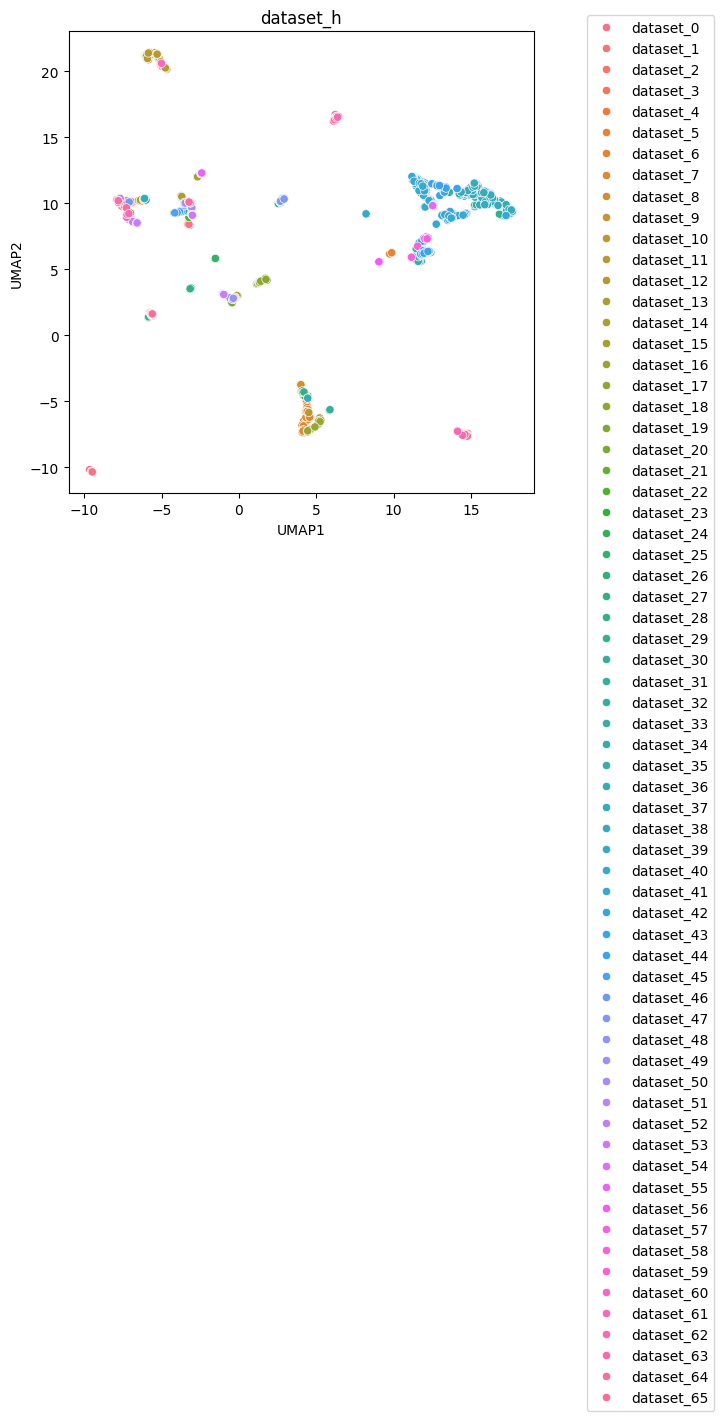

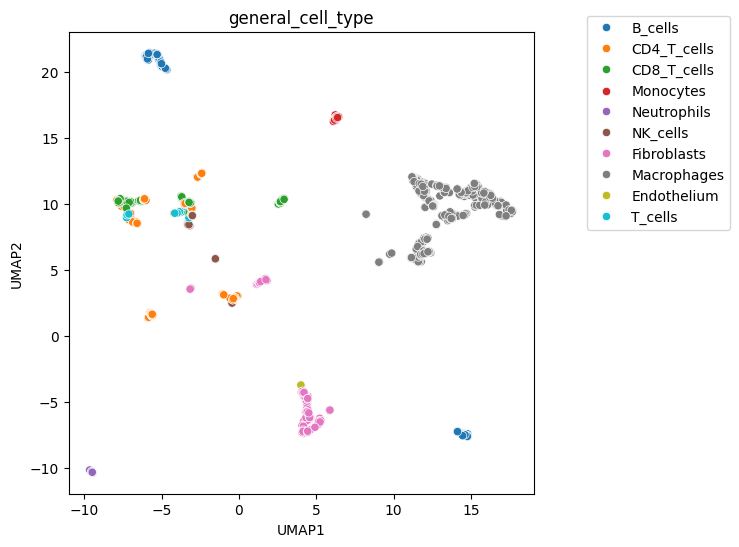

In [ ]:
for parameter in expr_normal_ann.loc[:, "dataset_h":"general_cell_type"]:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=umap_normal[:,0], y=umap_normal[:,1], hue=expr_normal_ann[parameter])
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(parameter)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

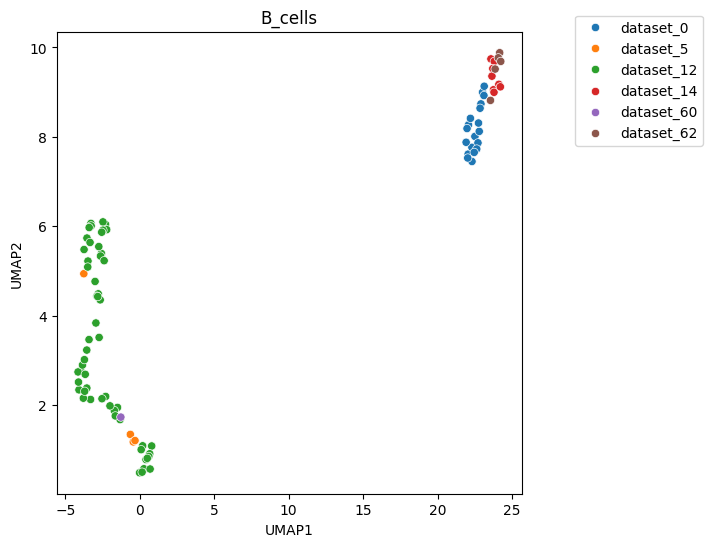

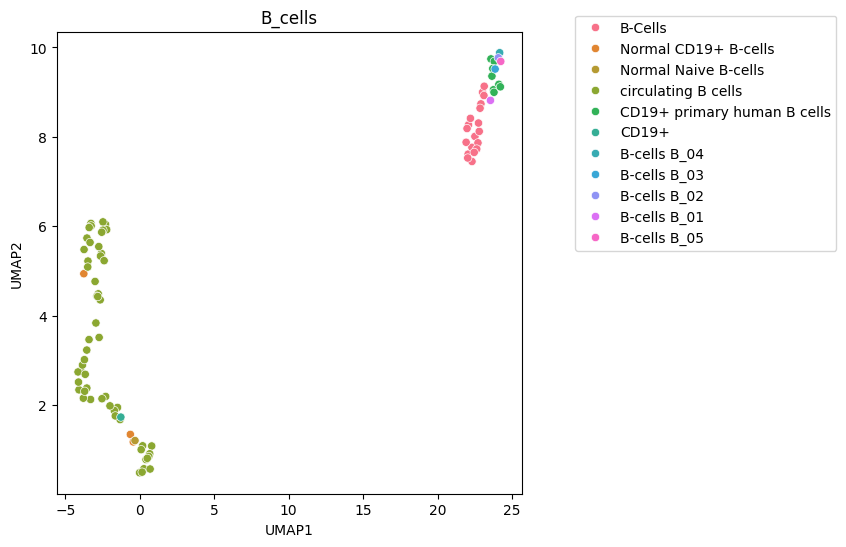

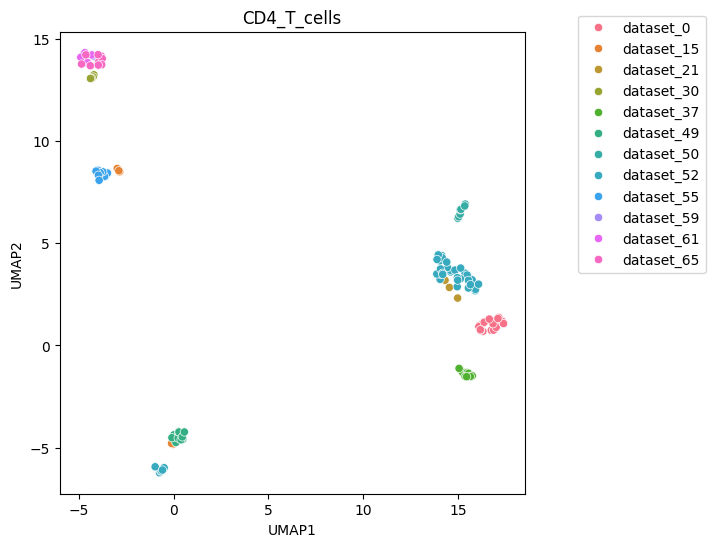

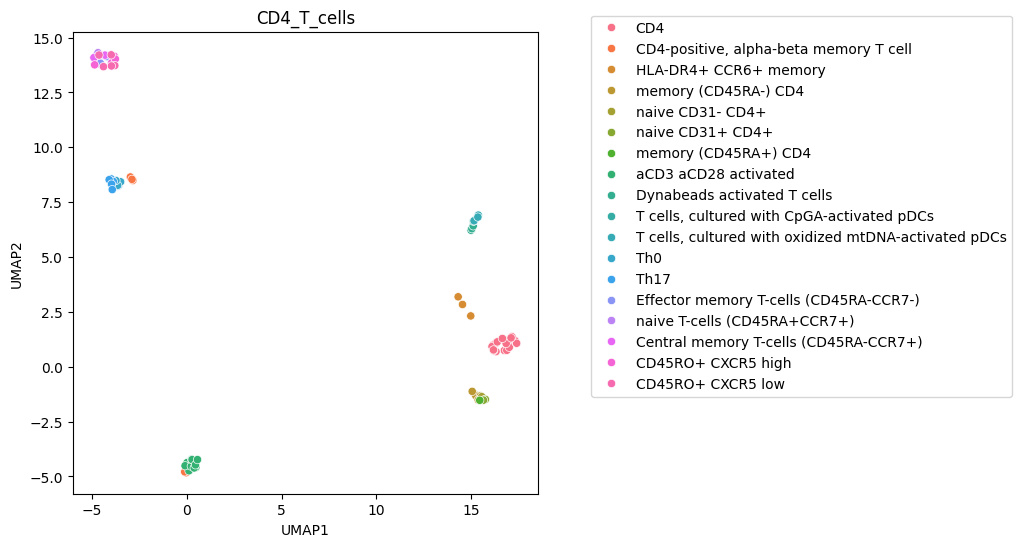

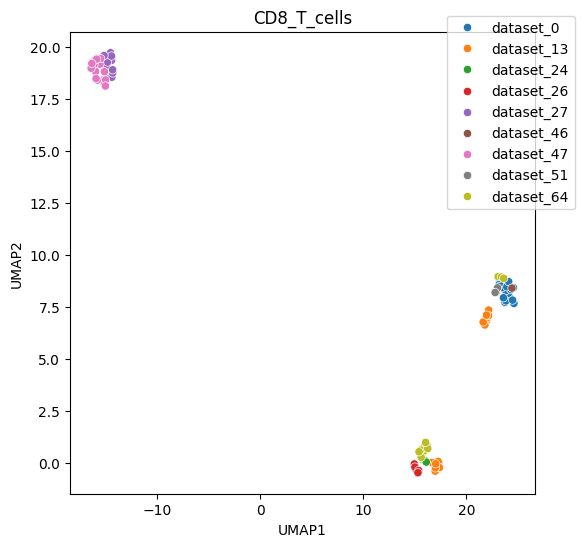

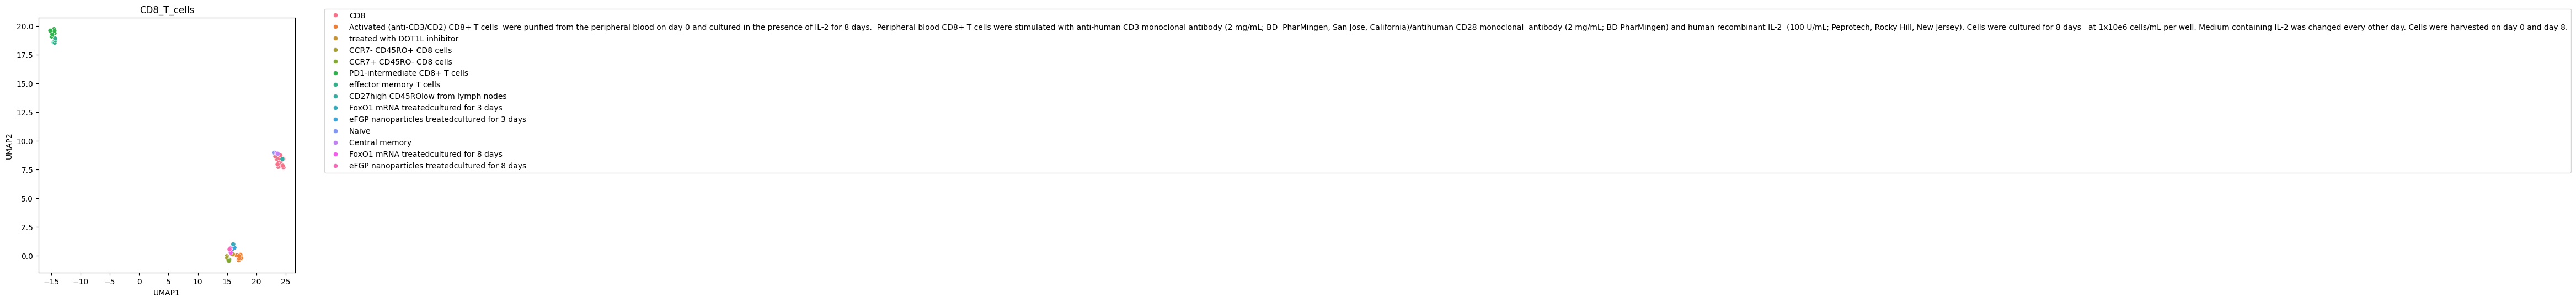

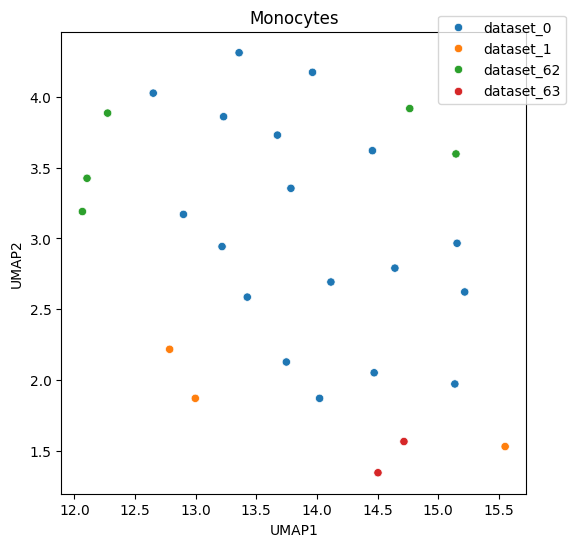

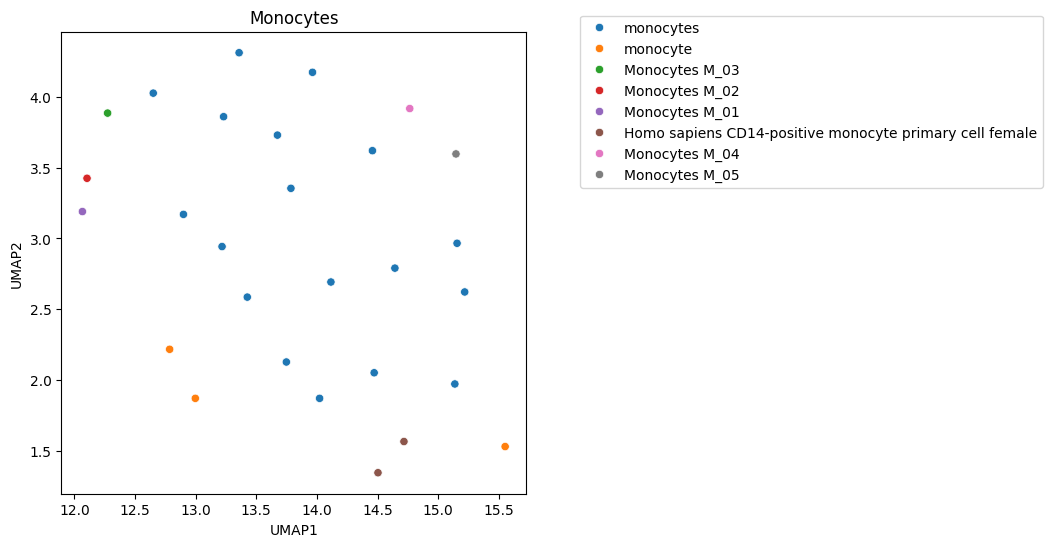

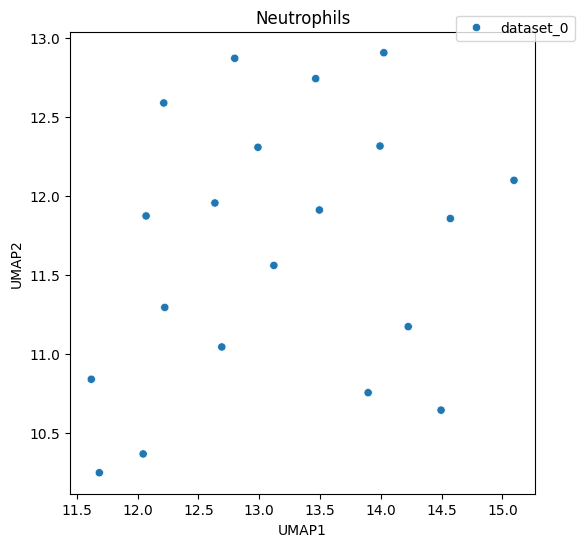

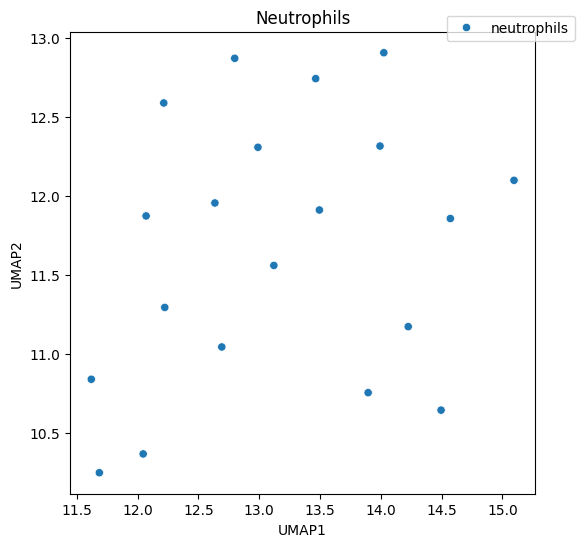

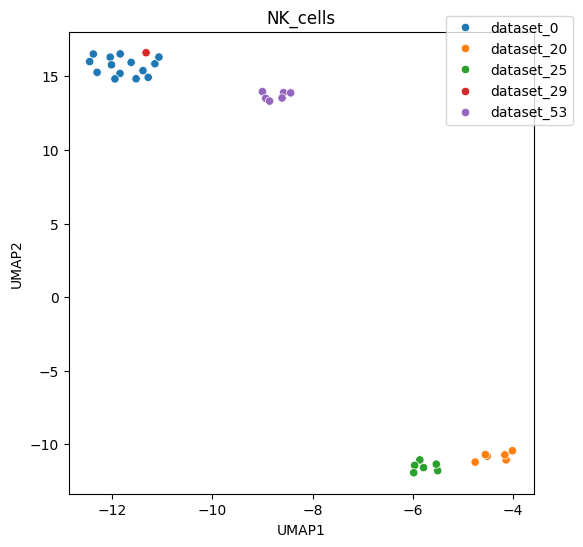

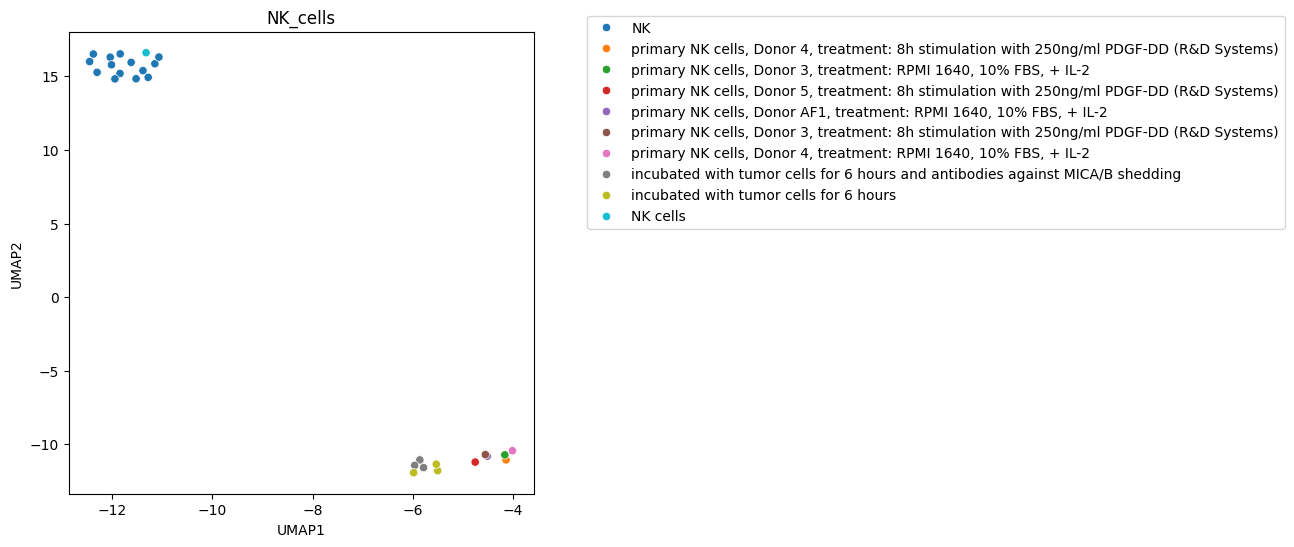

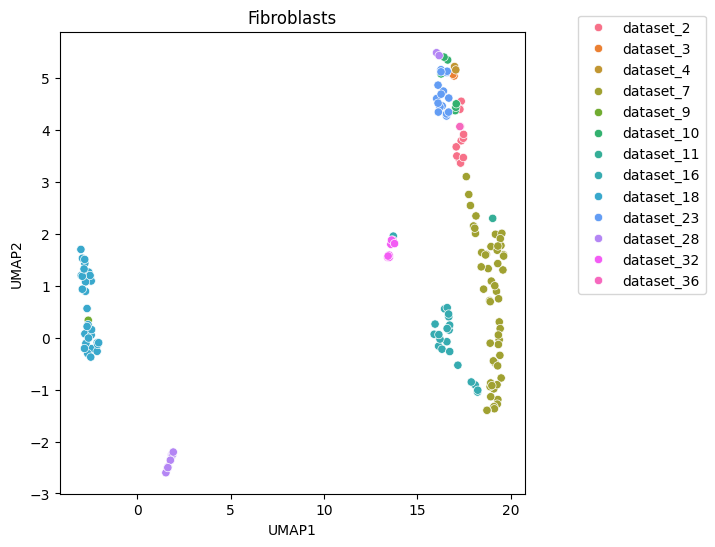

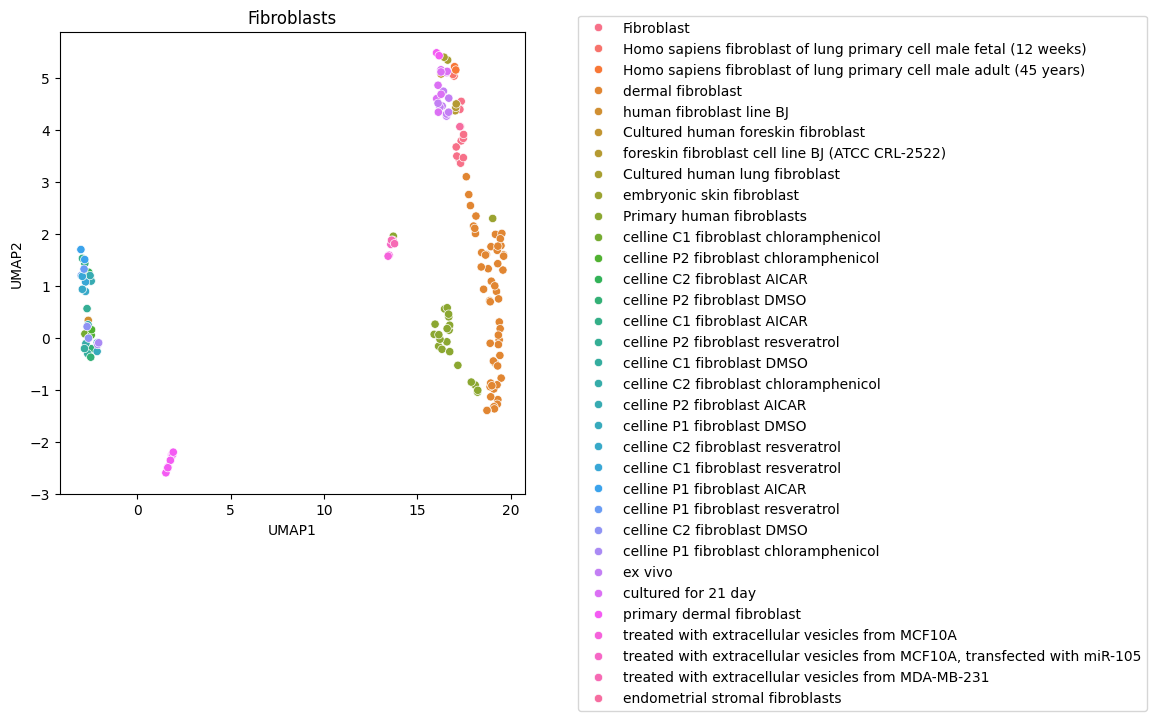

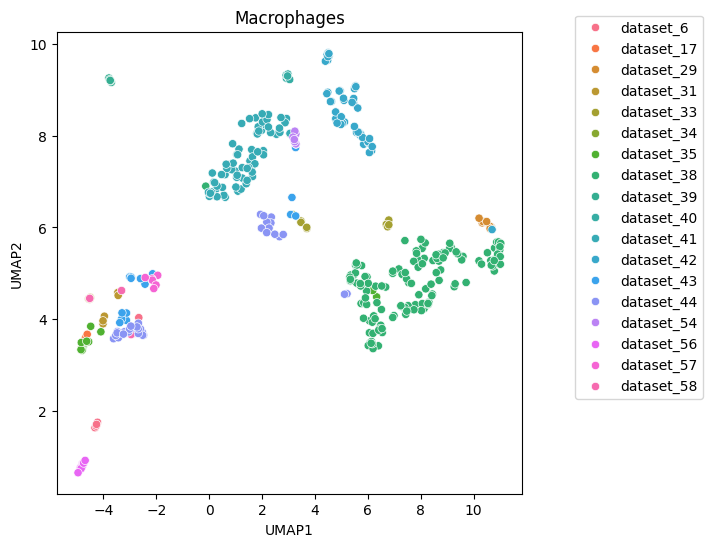

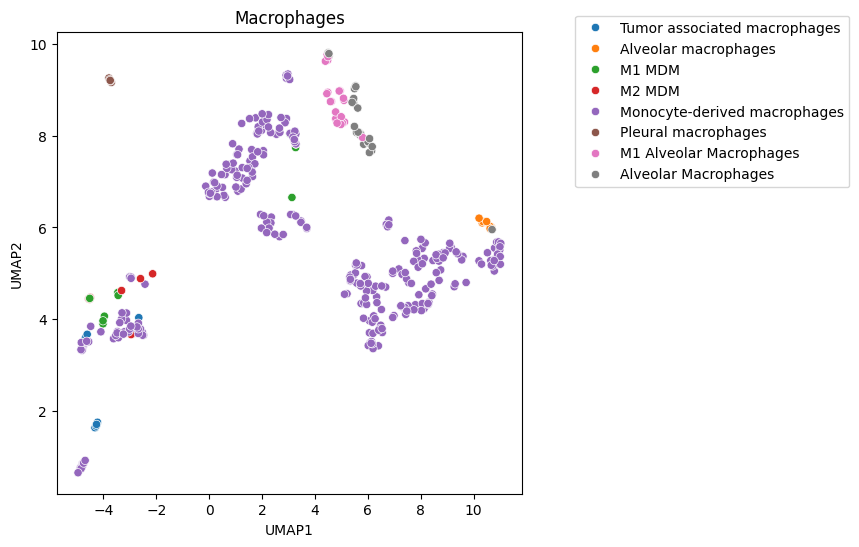

c:\Users\THUNDEROBOT\AppData\Local\PyMOL2\lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


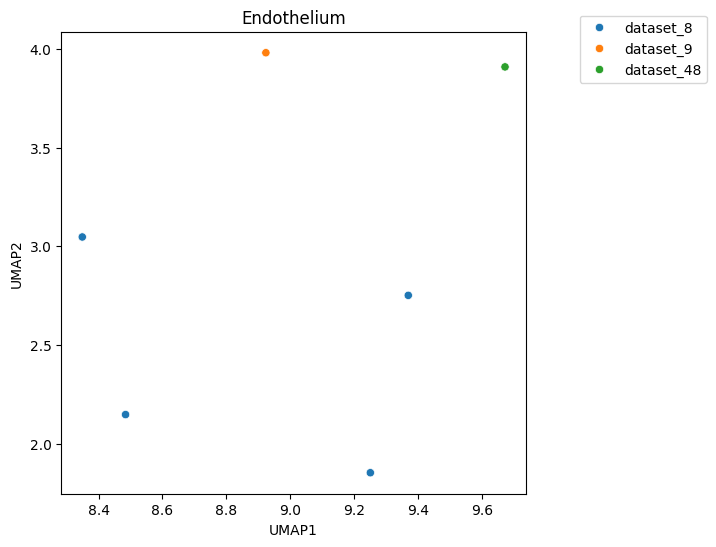

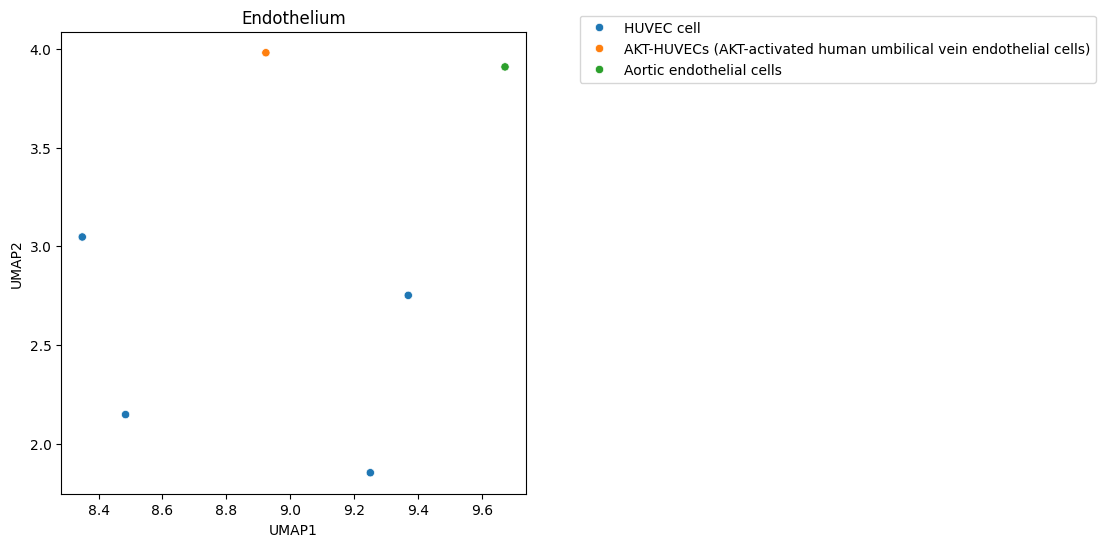

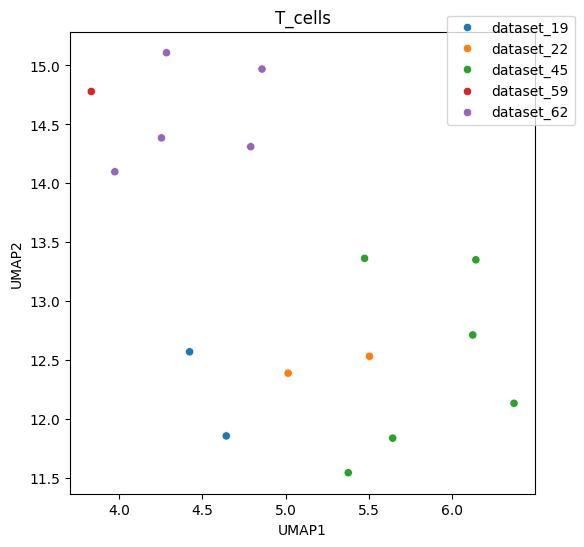

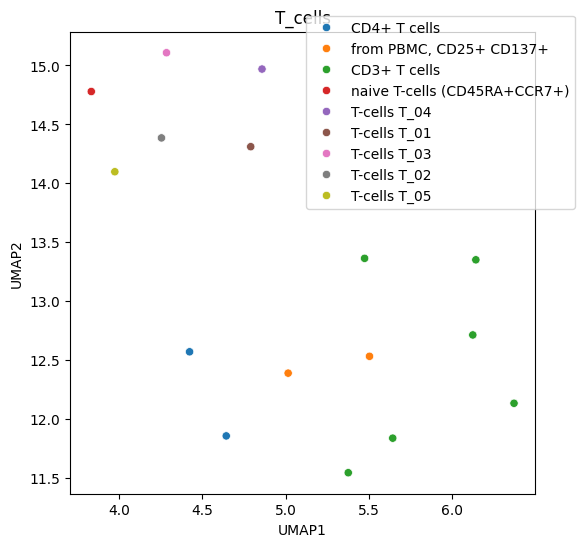

In [ ]:
for cells in ann_normal.general_cell_type.unique():
    umap = UMAP().fit_transform(expr_normal_ann.loc[expr_normal_ann.general_cell_type == cells].iloc[:, :20062])
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=umap[:,0], y=umap[:,1], hue=expr_normal_ann.loc[expr_normal_ann.general_cell_type == cells]['dataset_h'])
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(cells)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=umap[:,0], y=umap[:,1], hue=expr_normal_ann.loc[expr_normal_ann.general_cell_type == cells]['particular_cell_type'])
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(cells)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [ ]:
umap_cancer = UMAP().fit_transform(expr_cancer_ann.iloc[:, :20062])

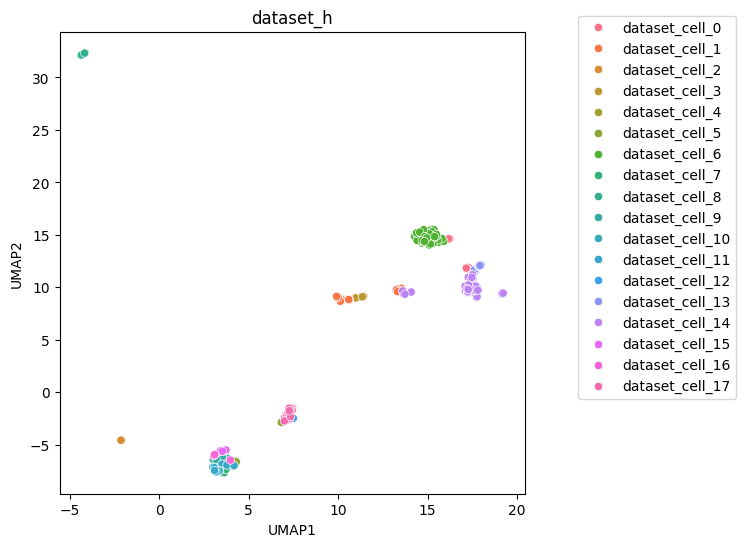

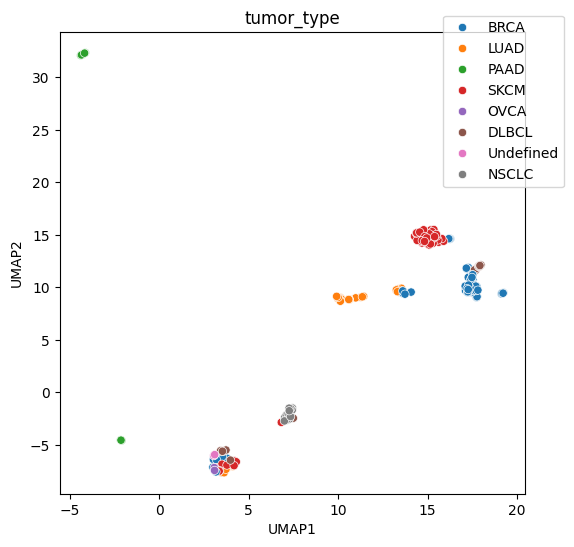

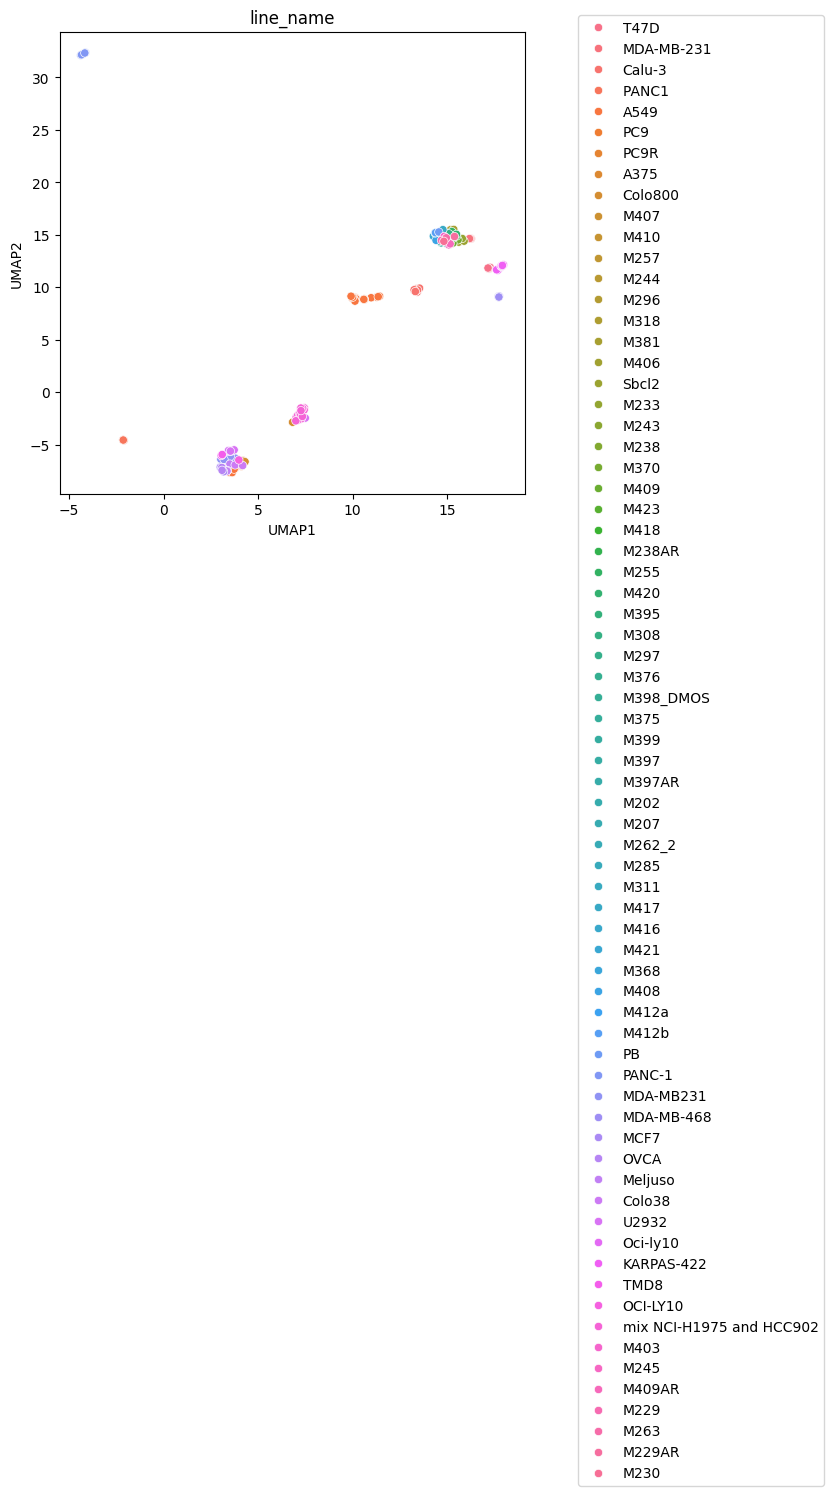

In [ ]:
for parameter in expr_cancer_ann.loc[:, "dataset_h":"line_name"]:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=umap_cancer[:,0], y=umap_cancer[:,1], hue=expr_cancer_ann[parameter])
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(parameter)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

# 1. Synthetic bulk RNA generation

In [8]:
cancer_log_types = pd.merge(np.log(expr_cancer + 1), ann_cancer[['srr_h', 'tumor_type']], left_index=True, right_on='srr_h').drop('srr_h', axis=1)
cancer_log_types = cancer_log_types.loc[cancer_log_types.tumor_type != 'Undefined'].rename(columns={"tumor_type": "cell_types"})
cancer_log_types

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk,cell_types
0,0.000000,0.011664,0.011227,0.089767,0.000000,3.503273,0.032664,3.576823,3.286920,0.000000,...,1.287449,2.257545,2.489204,1.780481,2.152075,3.757564,2.455859,2.989572,2.739568,BRCA
1,0.000000,0.047362,0.013650,0.140239,0.000000,2.760204,0.096214,3.075292,3.221765,0.000000,...,1.234190,2.462444,2.474030,1.931786,2.565224,3.074316,2.537558,2.699254,1.962871,BRCA
2,0.160342,0.023154,0.064289,0.036351,0.000000,2.669486,0.064540,2.746643,2.558820,2.379192,...,0.394374,1.993345,2.318589,1.069241,2.467838,4.865964,2.527829,2.690379,3.672723,BRCA
3,0.000000,0.042785,0.010834,0.053012,0.054842,2.771330,0.282358,3.357417,2.729443,1.829770,...,0.637257,1.611457,2.366015,1.122681,2.476674,4.912547,2.231356,3.075465,3.318734,BRCA
4,0.000000,0.077547,0.020707,0.209945,0.000000,3.528104,0.030240,3.662614,3.249942,0.032870,...,1.195706,2.115369,2.498249,1.494321,1.812383,4.048371,2.275562,2.644286,2.432923,BRCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.000000,0.491263,0.000000,0.259274,0.000000,1.902360,0.770766,4.011291,3.870299,3.753320,...,1.413561,2.628525,2.293340,1.186962,2.203802,4.482177,2.840921,3.464702,4.135897,LUAD
230,0.241106,0.297223,0.028758,0.141236,0.000000,1.968911,0.767273,3.650303,3.720623,3.483830,...,1.549519,2.587277,2.505722,0.934885,2.311736,4.157281,3.010449,3.290125,3.747239,LUAD
231,0.000000,0.837053,0.160409,0.292771,0.000000,2.556915,0.443943,4.150435,4.148532,2.680302,...,1.287494,2.391958,2.768822,0.815512,2.416037,4.193039,3.215213,3.005529,3.590568,LUAD
232,0.000000,0.314394,0.060098,0.232500,0.081314,2.029058,0.917047,3.814188,3.862422,3.471922,...,1.475326,2.508791,2.323916,1.077182,2.103527,4.375289,2.736844,3.352626,4.039370,LUAD


In [9]:
normal_log_types = pd.merge(np.log(expr_normal + 1), ann_normal[['srr_h', 'general_cell_type']], left_index=True, right_on='srr_h').drop('srr_h', axis=1)
normal_log_types = normal_log_types.rename(columns={"general_cell_type": "cell_types"})
normal_log_types

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk,cell_types
0,0.000000,0.099962,0.000000,0.135954,0.432747,0.000000,0.000000,3.040256,1.094884,0.0,...,2.595339,3.078339,3.601661,1.029432,1.962235,3.468878,3.324578,2.781372,1.675140,B_cells
1,0.000000,0.063831,0.000000,0.248271,0.000000,0.054767,0.000000,3.099570,1.098176,0.0,...,2.548993,3.199418,3.383663,0.628519,2.111780,3.329225,3.282280,2.832140,1.287634,B_cells
2,0.000000,0.015632,0.000000,0.499091,0.000000,0.000000,0.000000,3.058105,1.613175,0.0,...,2.748763,3.239178,3.537904,0.830309,2.211984,3.180845,3.370762,3.014975,1.025038,B_cells
3,0.000000,0.036713,0.114062,0.774267,0.000000,0.198848,0.000000,3.176707,1.413887,0.0,...,2.851915,3.254125,3.537302,0.735800,1.959005,3.728174,3.527793,2.877943,1.155661,B_cells
4,0.000000,0.042971,0.000000,0.722807,0.000000,0.200112,0.000000,3.032734,1.293820,0.0,...,2.818078,3.182542,3.348955,0.622580,1.926925,3.816077,3.192267,2.773663,1.134681,B_cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,0.000000,0.000000,6.361801,0.089921,0.000000,0.000000,0.172472,3.264424,2.466429,0.0,...,0.414864,1.217921,1.951252,0.027586,2.659185,6.455230,2.882480,2.716523,2.649102,Macrophages
984,0.003231,0.010031,5.268984,0.055503,0.000000,0.099648,0.056245,3.288816,1.900571,0.0,...,0.694518,1.122298,2.121216,0.072456,2.447055,6.360461,2.973049,2.866128,2.820294,Macrophages
985,0.000000,0.013934,0.000000,0.082971,0.000000,0.101521,0.000000,3.990867,3.140520,0.0,...,1.012533,1.470647,2.364253,0.299690,1.606810,5.446154,2.879060,2.863839,2.839890,CD8_T_cells
986,0.000000,0.019056,5.566320,0.285168,0.000000,0.262058,0.104734,3.110530,1.848314,0.0,...,0.516986,1.088918,1.958787,0.053425,2.485094,6.431753,3.079136,2.732563,2.638939,Macrophages


In [10]:
(normal_log_types.columns == cancer_log_types.columns).sum()

20063

In [11]:
common_data = pd.concat([normal_log_types, cancer_log_types])
common_data

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk,cell_types
0,0.000000,0.099962,0.000000,0.135954,0.432747,0.000000,0.000000,3.040256,1.094884,0.000000,...,2.595339,3.078339,3.601661,1.029432,1.962235,3.468878,3.324578,2.781372,1.675140,B_cells
1,0.000000,0.063831,0.000000,0.248271,0.000000,0.054767,0.000000,3.099570,1.098176,0.000000,...,2.548993,3.199418,3.383663,0.628519,2.111780,3.329225,3.282280,2.832140,1.287634,B_cells
2,0.000000,0.015632,0.000000,0.499091,0.000000,0.000000,0.000000,3.058105,1.613175,0.000000,...,2.748763,3.239178,3.537904,0.830309,2.211984,3.180845,3.370762,3.014975,1.025038,B_cells
3,0.000000,0.036713,0.114062,0.774267,0.000000,0.198848,0.000000,3.176707,1.413887,0.000000,...,2.851915,3.254125,3.537302,0.735800,1.959005,3.728174,3.527793,2.877943,1.155661,B_cells
4,0.000000,0.042971,0.000000,0.722807,0.000000,0.200112,0.000000,3.032734,1.293820,0.000000,...,2.818078,3.182542,3.348955,0.622580,1.926925,3.816077,3.192267,2.773663,1.134681,B_cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,0.000000,0.491263,0.000000,0.259274,0.000000,1.902360,0.770766,4.011291,3.870299,3.753320,...,1.413561,2.628525,2.293340,1.186962,2.203802,4.482177,2.840921,3.464702,4.135897,LUAD
230,0.241106,0.297223,0.028758,0.141236,0.000000,1.968911,0.767273,3.650303,3.720623,3.483830,...,1.549519,2.587277,2.505722,0.934885,2.311736,4.157281,3.010449,3.290125,3.747239,LUAD
231,0.000000,0.837053,0.160409,0.292771,0.000000,2.556915,0.443943,4.150435,4.148532,2.680302,...,1.287494,2.391958,2.768822,0.815512,2.416037,4.193039,3.215213,3.005529,3.590568,LUAD
232,0.000000,0.314394,0.060098,0.232500,0.081314,2.029058,0.917047,3.814188,3.862422,3.471922,...,1.475326,2.508791,2.323916,1.077182,2.103527,4.375289,2.736844,3.352626,4.039370,LUAD


In [12]:
n_cell_types = len(common_data.cell_types.unique())
n_cell_types

17

In [13]:
cell_types_list = list(common_data.cell_types.unique())
cell_types_list

['B_cells',
 'CD4_T_cells',
 'CD8_T_cells',
 'Monocytes',
 'Neutrophils',
 'NK_cells',
 'Fibroblasts',
 'Macrophages',
 'Endothelium',
 'T_cells',
 'BRCA',
 'LUAD',
 'PAAD',
 'SKCM',
 'OVCA',
 'DLBCL',
 'NSCLC']

In [14]:
def generate_sparse_proportions(n_cell_types, sparsity=0.5):
    # Create a random mask to set some proportions to zero
    mask = np.random.rand(n_cell_types) > sparsity  # Sparsity controls the fraction of zeros
    proportions = np.random.rand(n_cell_types) * mask  # Apply mask to generate sparse values

    # Check if all proportions are zero (sum = 0)
    if proportions.sum() == 0:
        # If all are zero, assign equal proportions to avoid NaN
        proportions = np.ones(n_cell_types)

    # Normalize to sum to 1
    proportions /= proportions.sum()
    return proportions

def generate_synthetic_bulk(data, cell_types_list, proportions):
    bulk_sample = np.zeros(data.shape[1] - 1)
    for cell_type in cell_types_list:
        sampled_row = data.loc[data.cell_types == cell_type].drop("cell_types", axis=1).sample(n=1)
        bulk_sample += sampled_row.to_numpy().squeeze() * proportions[cell_types_list.index(cell_type)]
    return bulk_sample

In [15]:
# Generate synthetic data
n_samples = 1000

X_synthetic = []
y_synthetic = []

for _ in range(n_samples):
    proportions = generate_sparse_proportions(n_cell_types, sparsity=0.5)
    synthetic_bulk = generate_synthetic_bulk(common_data, cell_types_list, proportions)
    X_synthetic.append(synthetic_bulk)
    y_synthetic.append(proportions)

# Convert to numpy arrays
X = np.array(X_synthetic)  # Shape: (n_samples, n_genes)
y = np.array(y_synthetic)  # Shape: (n_samples, n_cell_types)

print("X shape:", X.shape)  # Should be (n_samples, n_genes)
print("y shape:", y.shape)  # Should be (n_samples, n_cell_types)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X shape: (1000, 20062)
y shape: (1000, 17)
(800, 20062) (200, 20062) (800, 17) (200, 17)


# 2. Model creation, optimization and training

**1. Ridge regression model**

In [17]:
# Define objective function for Optuna
def objective(trial):
    # Suggest hyperparameter
    alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)  # Regularization strength

    # Train Ridge model
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)

    # Predict and calculate error
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Create study and optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2024-12-15 15:11:39,585] A new study created in memory with name: no-name-48a89fc3-122c-43c9-8085-d9df94f28f7f
<ipython-input-17-46e281095ab0>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)  # Regularization strength
[I 2024-12-15 15:11:40,329] Trial 0 finished with value: 1.3643320575675514e-05 and parameters: {'alpha': 0.0030365807401844876}. Best is trial 0 with value: 1.3643320575675514e-05.
<ipython-input-17-46e281095ab0>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform("alpha", 1e-4, 10.0)  # Regularization strength
[I 2024-12-15 15:11:41,323] Trial 1 finished with value: 1

Best Hyperparameters: {'alpha': 0.00010017772237424609}


In [16]:
# Train ridge regression model with best hyperparameter
model_ridge = Ridge(alpha=0.0001)
model_ridge.fit(X_train, y_train)

# Evaluate
y_pred = model_ridge.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))

MSE: 1.363957090420627e-05


In [19]:
for i in range(5):
    print(y_test[i])
    print(y_pred[i])

[0.10213639 0.08685297 0.09701067 0.         0.         0.17170247
 0.01913682 0.         0.12236694 0.         0.04668705 0.04480119
 0.10858874 0.13100256 0.         0.05682635 0.01288786]
[ 0.10115764  0.08787586  0.09542634 -0.00027147 -0.00048237  0.1718809
  0.01900308  0.00143677  0.12170707  0.00245151  0.04626022  0.0456673
  0.10859542  0.1306665  -0.00033366  0.05589488  0.01306401]
[0.         0.14185256 0.         0.17892765 0.21421313 0.
 0.         0.         0.         0.25274871 0.         0.
 0.         0.07733699 0.         0.0639696  0.07095137]
[-3.49770200e-04  1.36445715e-01  3.98224276e-03  1.80254806e-01
  2.14105032e-01  2.43066296e-05  2.33086860e-03 -2.67852517e-03
 -8.79212397e-05  2.54522427e-01  2.86572520e-03  9.99279020e-04
 -4.21634478e-04  7.58188176e-02  2.14174204e-06  6.32096053e-02
  6.89768844e-02]
[0.         0.13082617 0.         0.         0.18620478 0.04499502
 0.15228117 0.16962981 0.         0.         0.         0.
 0.         0.         0

**2. NN model**

In [31]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


# Define a custom neural network class
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, n_hidden_layers, n_neurons, activation_fn, dropout_rate):
        super(NeuralNetwork, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_dim, n_neurons))
        layers.append(activation_fn)

        # Hidden layers
        for _ in range(n_hidden_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(activation_fn)
            layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(n_neurons, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return torch.softmax(self.model(x), dim=1)  # Ensure proportions sum to 1


# Define the Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 3)
    n_neurons = trial.suggest_int("n_neurons", 32, 256)
    activation_fn_name = trial.suggest_categorical("activation_fn", ["ReLU", "Tanh"])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    n_epochs = trial.suggest_int("n_epochs", 50, 200)

    # Map activation function
    if activation_fn_name == "ReLU":
        activation_fn = nn.ReLU()
    elif activation_fn_name == "Tanh":
        activation_fn = nn.Tanh()

    # Initialize the model
    model = NeuralNetwork(
        input_dim=20062,
        output_dim=n_cell_types,
        n_hidden_layers=n_hidden_layers,
        n_neurons=n_neurons,
        activation_fn=activation_fn,
        dropout_rate=dropout_rate,
    )

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create DataLoader for mini-batch training
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    model.train()
    for epoch in range(n_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor)
        mse = mean_squared_error(y_test, y_pred_test.numpy())

    return mse


# Optimize the neural network with Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2024-12-15 15:37:04,194] A new study created in memory with name: no-name-ab5e4b99-3607-482c-b7ff-7dc1bf7d437b
<ipython-input-31-bb4bfbee5991>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1)
[I 2024-12-15 15:38:20,831] Trial 0 finished with value: 0.06144355468649773 and parameters: {'n_hidden_layers': 3, 'n_neurons': 84, 'activation_fn': 'Tanh', 'dropout_rate': 0.04938491126982825, 'lr': 0.0630864399781241, 'batch_size': 64, 'n_epochs': 159}. Best is trial 0 with value: 0.06144355468649773.
<ipython-input-31-bb4bfbee5991>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-1

KeyboardInterrupt: 

**Ridge regression model allows to achieve lower MSE metric value (about e-5) than NN model (about e-3).**

# 3. Prediction for provided data

In [32]:
bulk_LUAD = pd.read_csv('LUAD-expr.tsv', sep='\t', index_col=0).T
bulk_normal = pd.read_csv('Normal-blood-expr.tsv', sep='\t', index_col=0).T

In [33]:
bulk_LUAD

Gene,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
VIC-020-CL,0.13965,0.050278,166.111953,0.220864,0.153432,6.714810,0.081386,11.871257,8.696697,5.871538,...,13.169343,4.323443,12.412860,18.033103,0.665761,6.845210,105.675717,19.454571,18.236796,9.935738
VIC-025-CL,0.00000,0.041802,284.024569,326.314670,0.835218,54.048979,0.265322,14.094609,15.518646,2.454418,...,18.701137,2.649721,7.208214,14.198499,0.443561,7.915771,129.416355,18.618073,12.569798,19.745376
VIC-026-CL,0.00000,0.010439,77.175170,0.224573,0.147834,1.911275,0.039353,12.882029,15.616836,0.278233,...,15.537623,1.254031,2.694881,5.436411,0.242960,2.580821,68.997328,6.589486,6.378963,4.738366
VIC-031-CL,0.00000,0.008841,43.849792,15.032036,0.086907,18.937685,0.023123,10.021435,11.295154,3.516083,...,10.643111,1.696066,2.863296,14.871471,0.383966,4.861970,62.453913,7.350715,8.626832,12.997406
VIC-033-CL,0.00000,0.006627,19.417069,0.150320,0.140815,3.898017,0.000000,23.091671,60.043828,0.328406,...,47.539646,0.989941,5.501085,20.664628,0.112162,11.114233,117.982170,14.633831,22.348920,8.242817
VIC-034-CL,0.00000,0.005353,173.169681,0.016456,0.000000,9.045750,0.211994,12.020901,6.423144,0.592946,...,9.087278,1.368627,2.832940,9.184834,0.056883,5.667555,206.680326,5.887001,9.171042,8.089103


In [52]:
bulk_LUAD.iloc[0:10].sum(axis=1)

,0
VIC-020-CL,1000000.0
VIC-025-CL,1000000.0
VIC-026-CL,1000000.0
VIC-031-CL,1000000.0
VIC-033-CL,1000000.0
VIC-034-CL,1000000.0


In [34]:
bulk_normal

Gene,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU18,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338
SampleA,34.9110,0.0,0.350236,16.109280,5.933075,0.038071,6.472901,0.977478,1.114301,0.000000,...,0.0,0.0,0.00000,0.0,32.9590,0.0,0.0,10.36762,0.0,110.647690
SampleB,52.7754,0.0,0.000000,19.539665,5.526135,0.046603,7.923150,0.849347,0.412397,0.123665,...,0.0,0.0,2.71479,0.0,10.5042,0.0,0.0,6.12038,0.0,65.794971


In [53]:
bulk_normal.iloc[0:10].sum(axis=1)

,0
SampleA,9.999999e+05
SampleB,1.000000e+06


In [54]:
# Predict proportions for real bulk data
bulk_LUAD_proportions = model_ridge.predict(np.log(bulk_LUAD[common_data.drop("cell_types", axis=1).columns] + 1).values)
bulk_normal_proportions = model_ridge.predict(np.log(bulk_normal[common_data.drop("cell_types", axis=1).columns] + 1).values)

In [63]:
for i in range(len(bulk_normal.index)):
    print(bulk_normal.index[i])
    print(dict(zip(cell_types_list, [0.0 if i < 0.01 else round(i,2) for i in list(bulk_normal_proportions[i])])))

SampleA
{'B_cells': 0.04, 'CD4_T_cells': 0.19, 'CD8_T_cells': 0.09, 'Monocytes': 0.28, 'Neutrophils': 0.0, 'NK_cells': 0.13, 'Fibroblasts': 0.0, 'Macrophages': 0.01, 'Endothelium': 0.0, 'T_cells': 0.25, 'BRCA': 0.0, 'LUAD': 0.0, 'PAAD': 0.0, 'SKCM': 0.0, 'OVCA': 0.0, 'DLBCL': 0.0, 'NSCLC': 0.0}
SampleB
{'B_cells': 0.08, 'CD4_T_cells': 0.19, 'CD8_T_cells': 0.15, 'Monocytes': 0.27, 'Neutrophils': 0.02, 'NK_cells': 0.01, 'Fibroblasts': 0.0, 'Macrophages': 0.0, 'Endothelium': 0.0, 'T_cells': 0.25, 'BRCA': 0.02, 'LUAD': 0.01, 'PAAD': 0.0, 'SKCM': 0.02, 'OVCA': 0.0, 'DLBCL': 0.0, 'NSCLC': 0.0}


In [62]:
for i in range(len(bulk_LUAD.index)):
    print(bulk_LUAD.index[i])
    print(dict(zip(cell_types_list, [0.0 if i < 0.01 else round(i,2) for i in list(bulk_LUAD_proportions[i])])))

VIC-020-CL
{'B_cells': 0.21, 'CD4_T_cells': 0.1, 'CD8_T_cells': 0.2, 'Monocytes': 0.0, 'Neutrophils': 0.0, 'NK_cells': 0.0, 'Fibroblasts': 0.03, 'Macrophages': 0.37, 'Endothelium': 0.0, 'T_cells': 0.0, 'BRCA': 0.1, 'LUAD': 0.06, 'PAAD': 0.0, 'SKCM': 0.0, 'OVCA': 0.03, 'DLBCL': 0.0, 'NSCLC': 0.09}
VIC-025-CL
{'B_cells': 0.1, 'CD4_T_cells': 0.0, 'CD8_T_cells': 0.03, 'Monocytes': 0.0, 'Neutrophils': 0.05, 'NK_cells': 0.02, 'Fibroblasts': 0.06, 'Macrophages': 0.42, 'Endothelium': 0.05, 'T_cells': 0.1, 'BRCA': 0.23, 'LUAD': 0.08, 'PAAD': 0.0, 'SKCM': 0.0, 'OVCA': 0.0, 'DLBCL': 0.03, 'NSCLC': 0.01}
VIC-026-CL
{'B_cells': 0.28, 'CD4_T_cells': 0.04, 'CD8_T_cells': 0.21, 'Monocytes': 0.0, 'Neutrophils': 0.03, 'NK_cells': 0.0, 'Fibroblasts': 0.0, 'Macrophages': 0.42, 'Endothelium': 0.02, 'T_cells': 0.0, 'BRCA': 0.18, 'LUAD': 0.07, 'PAAD': 0.0, 'SKCM': 0.0, 'OVCA': 0.03, 'DLBCL': 0.0, 'NSCLC': 0.07}
VIC-031-CL
{'B_cells': 0.31, 'CD4_T_cells': 0.0, 'CD8_T_cells': 0.18, 'Monocytes': 0.0, 'Neutrophi